In [1]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%cd APE_paper/docs/figures_notebooks
!git checkout YvonneJohansson

'rm' is not recognized as an internal or external command,
operable program or batch file.


[WinError 3] The system cannot find the path specified: 'APE_paper/docs/figures_notebooks'
C:\Users\Yvonne\Documents\Hernando_APE_paper\APE_paper\docs\figures_notebooks


Cloning into 'APE_paper'...
error: invalid path 'graphs_excel_format/figure_ED10e.xlsx:Zone.Identifier'
fatal: unable to checkout working tree
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'

C:\Users\Yvonne\.conda\envs\HMV_environment\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


D	data/TS20_20230512_RTC_restructured_data.pkl
D	data/TS20_20230512_RTC_smoothed_signal.npy
M	scripts/YJ_analysis_utils.py
Your branch is up to date with 'origin/YvonneJohansson'.


Already on 'YvonneJohansson'


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import urllib.request
from os.path import exists
import matplotlib.pylab as plt
import numpy as np
import pickle
from scipy.signal import decimate

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))))
from scripts import YJ_analysis_utils as yj_utils
from scripts import yj_plotting as yj_plot

In [5]:
# # Extended Data 5S & 5T:

# Get dataset information:
dataset_name = 'DataOverview_ED5PQR.csv' # CORRECT TO NEW FIGURE NUMBER
zenodo = "https://zenodo.org/records/xxxxxxxxxxx/files/"
url = zenodo + dataset_name
dataset_path = '../../data/' + dataset_name

if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('DataOverview already in directory')

#print(dataset_path)
info = pd.read_csv(dataset_path)

DataOverview already in directory


In [4]:
info

,Unnamed: 0,AnimalID,Date,fiber_side,protocol1
0,1,TS24,20230929,right,SOR
1,2,TS26,20230918,right,SOR
2,3,TS27,20231003,right,SOR
3,4,TS32,20231026,right,SOR
4,5,TS33,20231102,right,SOR
5,6,TS34,20231031,right,SOR


Return trials: 120 cue on, 246 cue off, total cue on % : 32.79
Return trials: 155 cue on, 120 cue off, total cue on % : 56.36
Return trials: 253 cue on, 262 cue off, total cue on % : 49.13
Return trials: 133 cue on, 102 cue off, total cue on % : 56.60
Return trials: 118 cue on, 86 cue off, total cue on % : 57.84
Return trials: 103 cue on, 77 cue off, total cue on % : 57.22


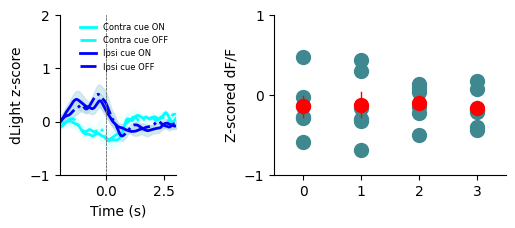

In [39]:
all_group_data = {'SOR_return_cueON_contra': [], 'SOR_return_cueOFF_contra': [], 'SOR_return_cueON_ipsi': [], 'SOR_return_cueOFF_ipsi': []}

APE_choice_peak_values = []
return_contra_cue_on_values = []
return_contra_cue_off_values = []
return_ipsi_cue_on_values = []
return_ipsi_cue_off_values = []

for i, mouse in enumerate(info['AnimalID']):
    date = str(info['Date'][i])
    fiber_side = info['fiber_side'][i]
    protocol = info['protocol1'][i]
    dataset_names = []
    nr_return_trials_cue_on = 0
    nr_return_trials_cue_off = 0
    CoT_trial_dataname = mouse + '_' + date + '_restructured_data.pkl'
    CoT_photo_dataname = mouse + '_' + date + '_smoothed_signal.npy' 
    dataset_names.extend([CoT_photo_dataname,CoT_trial_dataname])
    url = zenodo + dataset_name
    for j, dataset_name in enumerate(dataset_names): 
        dataset_path = '../../data/' + dataset_name
        if not exists(dataset_path):
            print('Downloading ' + dataset_name)
            urllib.request.urlretrieve(url, dataset_path)
        #else:
        #   print(dataset_name + ' already in directory')
        
        if j == 0:
            photometry_data = np.load(dataset_path)  
        if j == 1:  
            trial_data = pd.read_pickle(dataset_path)
            session_traces = yj_utils.SessionData(mouse, date, fiber_side, protocol, trial_data, photometry_data)

    alignements = ['SOR_choice','SOR_return_cueON_contra','SOR_return_cueOFF_contra', 'SOR_return_cueON_ipsi', 'SOR_return_cueOFF_ipsi']
    for a, alignement in enumerate(alignements):
        if alignement == 'SOR_choice':
            curr_data = session_traces.SOR_choice.contra_data
        elif alignement == 'SOR_return_cueON_contra':
            curr_data = session_traces.SOR_return_cueON.contra_data
        elif alignement == 'SOR_return_cueOFF_contra':
            curr_data = session_traces.SOR_return_cueOFF.contra_data
        elif alignement == 'SOR_return_cueON_ipsi':
            curr_data = session_traces.SOR_return_cueON.ipsi_data
        elif alignement == 'SOR_return_cueOFF_ipsi':
            curr_data = session_traces.SOR_return_cueOFF.ipsi_data

        curr_data_mean = decimate(curr_data.mean_trace, 10) # data aligned to start of return movement

        if alignement != 'SOR_choice':
            # all return data is aligned to the start of return movement (=side port out)
            # to align it to the return cue instead, which happens 20ms after side port out, it needs to be shifted: 
            t1 = np.pad(curr_data_mean, (0, 20))  # pad with 20 zeros (20ms with 10Hz sampling = 200, however decimate 10 above, hence only 20 datapoints)
            t2 = t1[20:]
            curr_data_mean = t2
            all_group_data[alignement].append(curr_data_mean)

        curr_data_time = decimate(curr_data.time_points, 10)
        curr_data_traces = decimate(curr_data.sorted_traces, 10)
        

        if alignement == 'SOR_choice':
            # extract how long it takes on average to the peak movement signal in a classic contra trial (center --> side port)
            start_inx = 8000
            APE_choice_time_range = curr_data_time[start_inx:start_inx + 8000]
            APE_choice_peak_index = np.argmax(curr_data_mean[start_inx:start_inx + 8000])

        # extract movement after the same time interval in the return trials: 
        amplitude = curr_data_mean[start_inx + APE_choice_peak_index]
        
        if alignement == 'SOR_return_cueON_contra':
            nr_return_trials_cue_on = nr_return_trials_cue_on + curr_data_traces.shape[0]
            return_contra_cue_on_values.append(amplitude)
        elif alignement == 'SOR_return_cueOFF_contra':
            nr_return_trials_cue_off = nr_return_trials_cue_off + curr_data_traces.shape[0]
            return_contra_cue_off_values.append(amplitude)
        elif alignement == 'SOR_return_cueON_ipsi':    
            nr_return_trials_cue_on = nr_return_trials_cue_on + curr_data_traces.shape[0]
            return_ipsi_cue_on_values.append(amplitude)
        elif alignement == 'SOR_return_cueOFF_ipsi':
            nr_return_trials_cue_off = nr_return_trials_cue_off + curr_data_traces.shape[0]
            return_ipsi_cue_off_values.append(amplitude)
        
    #print(f"Return trials: {nr_return_trials_cue_on:.0f} cue on, {nr_return_trials_cue_off:.0f} cue off, total cue on % : {(nr_return_trials_cue_on*100 / (nr_return_trials_cue_on + nr_return_trials_cue_off)):.2f}")
        

figure = yj_plot.plot_ED5ST(all_group_data, curr_data_time, return_contra_cue_on_values, return_contra_cue_off_values, return_ipsi_cue_on_values, return_ipsi_cue_off_values)

            